# Region properties and quantification

The object of image analysis usually requires to extract various features and properties of objects. This provides quantitative values allowing analysis of the image or can be used for further analysis. In this notebook we will cover how to extract quantification of object using pyclesperanto.

In [15]:
import pyclesperanto as cle
import numpy as np
import pandas as pd
from skimage import io
from matplotlib import pyplot as plt

## Load and prepare data to quantify

Let's quickly load an test image and segment it in order after to extract features and quantification from it. In this case we will use `blob` as input data and apply a `voronoi_otsu_labeling` to segment it and `exclude_labels_on_edges` to remove edge object that could biais our quantification. 

For more info on these processes you can check the [voronoi_otsu_labeling notebook](./voronoi_otsu_labeling.ipynb) and the [thresholding notebook](./thresholding.ipynb).

In [11]:
image = io.imread('https://samples.fiji.sc/blobs.png').squeeze()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(254, 256), dtype=uint32, mtype=buffer)
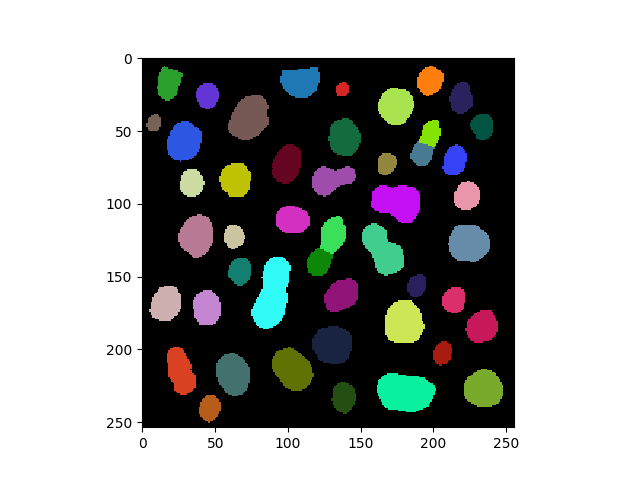

In [12]:
labeled = cle.voronoi_otsu_labeling(image, spot_sigma=4, outline_sigma=1)
labeled_cleanned = cle.exclude_labels_on_edges(labeled)
labeled_cleanned

## Quantifications of labels

Once satisfied with the segmentation, we can move on to quantification and analysis of the segmented objects.

A first and easy information we can extract is the number of objects in the image

In [17]:
# The maximium intensity in a label image corresponds to the number of objects
num_labels = cle.maximum_of_all_pixels(labeled_cleanned)
print("Number of objects in the image: " + str(num_labels))

Number of objects in the image: 47.0


Otherwise we can run an analysis of each labelled using `statistics_of_labelled_pixels`. This function will operate on a labelled image and can also take an intensity image to extract various geometrical and intensity wise quantifications, similarly to `regionprops_table` from [scikit-image]().

In [16]:
df = pd.DataFrame(
    cle.statistics_of_labelled_pixels(image, labeled_cleanned)
    )
df.head()

,max_distance_to_mass_center,mean_distance_to_centroid,mean_distance_to_mass_center,sum_distance_to_centroid,centroid_y,max_distance_to_centroid,sum_y,centroid_x,mass_center_z,mass_center_y,...,sum_distance_to_mass_center,bbox_depth,bbox_max_y,centroid_z,bbox_max_z,bbox_max_x,bbox_min_z,bbox_min_y,bbox_min_x,label
0,14.748025,8.234445,8.237642,3730.203613,16.584990,14.969856,7513.0,108.501106,0.0,16.449530,...,3731.651855,1.0,27.0,0.0,0.0,121.0,0.0,7.0,95.0,1.0
1,10.446603,6.328997,6.328996,1772.119019,15.803572,10.456557,4425.0,197.317856,0.0,15.809253,...,1772.118774,1.0,26.0,0.0,0.0,206.0,0.0,6.0,189.0,2.0
2,11.823785,6.686841,6.687099,1979.304810,17.442568,11.818239,5163.0,17.956081,0.0,17.350586,...,1979.381348,1.0,29.0,0.0,0.0,27.0,0.0,6.0,10.0,3.0
3,5.240184,3.265794,3.265909,244.934540,21.760000,5.248460,1632.0,137.093338,0.0,21.749187,...,244.943207,1.0,26.0,0.0,0.0,141.0,0.0,17.0,133.0,4.0
4,9.204876,5.690794,5.692323,1291.810181,26.083700,9.053936,5921.0,44.572689,0.0,25.920603,...,1292.157349,1.0,35.0,0.0,0.0,52.0,0.0,18.0,37.0,5.0


The function `cle.statistics_of_labelled_pixels` will extract a list of primary measurement, such as object area, centroids, bounding box, etc. A few thing to know on the function:
- most measurement unit are in pixels, pyclesperanto does not take in account data calibration in its computation
- not all measurement are available, if we compare with some other library with similar function (e.g. scikit-image) some measurement cannot be computed by GPU

With such measurement it is possible to isolate specific object like the smallest or biggest structure in the image.

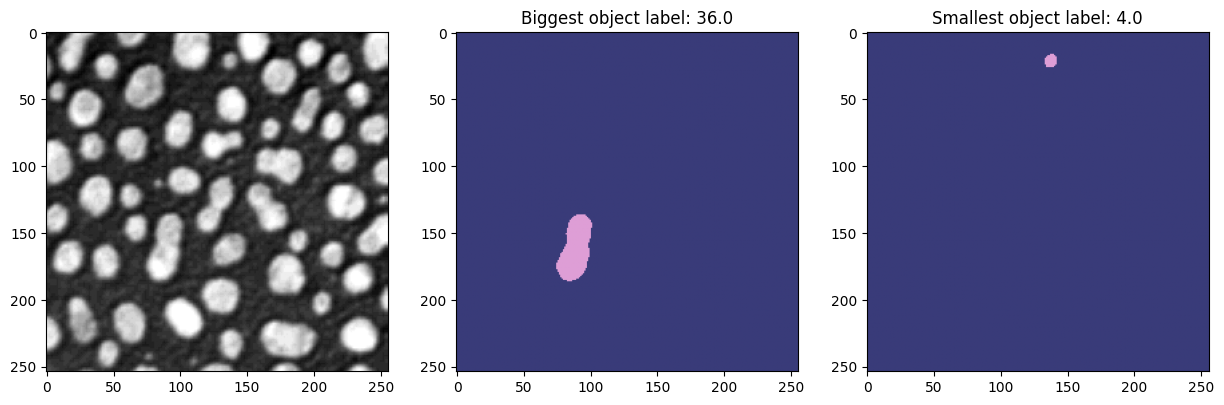

In [18]:
# get the label with the largest area from the df 
largest_label = df.loc[df['area'].idxmax()]['label']
smalest_label = df.loc[df['area'].idxmin()]['label']

biggest = cle.equal_constant(labeled_cleanned, scalar=largest_label)
smallest = cle.equal_constant(labeled_cleanned, scalar=smalest_label)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(image, cmap='gray')
axs[1].imshow(biggest, cmap='tab20b')
axs[1].set_title('Biggest object label: ' + str(largest_label))
axs[2].imshow(smallest, cmap='tab20b')
axs[2].set_title('Smallest object label: ' + str(smalest_label))
plt.show()

We can also explore and visualize quantifications as [parametric maps](./parametric_maps.ipynb)